# ⚡ Training Workflow (1–14)
이 구간은 빠르게 데이터 일부로 end-to-end 학습과 검증을 수행하는 스모크 테스트 플로우입니다. 아래 순서대로 각 셀을 실행하세요.

# 1. Import required libraries


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import sys, math, json, random, contextlib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch_geometric.datasets import AirfRANS
from torch_geometric.data import Data, Batch
from matplotlib.tri import Triangulation
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch_geometric.data import Data
from navier_stokes_physics_loss import NavierStokesPhysicsLoss
from airfrans_utils import prepare_airfrans_graph_for_physics, estimate_node_area, build_bc_masks_airfrans



def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_seed(42)
print('SmokeTest | PyTorch:', torch.__version__, '| CUDA?', torch.cuda.is_available())

SmokeTest | PyTorch: 2.8.0+cu128 | CUDA? True


# 2. Set Configuration

In [2]:
# 2) Configuration (minimal for smoke)
from dataclasses import dataclass, asdict

@dataclass
class SmokeCfg:
    seed: int = 42
    task: str = 'scarce'
    root: str = 'Dataset'
    # subsample graph count for smoke
    limit_train: int = 180
    limit_val: int = 20
    # voxel/node subsampling targets
    target_min_nodes: int = 8_000
    target_max_nodes: int = 30_000
    voxel_frac: float = 0.01
    voxel_iters: int = 5
    # radius-graph
    global_radius: float = 0.02
    surface_radius: float = 0.01
    max_num_neighbors: int = 48
    surface_ring: bool = True
    # training
    batch_size: int = 1
    epochs: int = 100
    hidden: int = 128
    layers: int = 8
    lr: float = 4e-4
    weight_decay: float = 1e-2  # typical AdamW wd
    betas: tuple[float, float] = (0.9, 0.95)
    eps: float = 1e-8
    amp: bool = False
    # lr scheduler: 'cosine', 'cosine_warm_restarts', 'reduce_on_plateau', or None
    lr_scheduler: str | None = 'reduce_on_plateau'
    # cosine params
    cosine_T_max: int = 100  # epochs
    cosine_eta_min: float = 1e-6
    # warm restarts params
    wr_T_0: int = 10
    wr_T_mult: int = 1
    wr_eta_min: float = 1e-6
    # reduce on plateau params
    rop_factor: float = 0.5
    rop_patience: int = 5
    rop_min_lr: float = 1e-6
    # Global Context & Attention Configuration
    use_global_tokens: bool = True           # Enable/disable global tokens
    num_global_tokens: int = 4               # Number of global tokens
    attention_heads: int = 4                 # Multi-head attention heads
    attention_layers: int = 8                # Number of transformer layers
    attention_dropout: float = 0.0           # Attention dropout rate
    use_cross_attention: bool = True         # Cross-attention between local and global
    global_pooling_type: str = 'attention'   # 'mean', 'max', 'attention', 'set2set'
    positional_encoding: bool = True         # Use positional encoding
    pos_encoding_max_len: int = 50000        # Max sequence length for positional encoding
    # Advanced attention options
    use_residual_attention: bool = True      # Residual connections in attention
    attention_normalization: str = 'layer'   # 'layer', 'batch', 'rms'
    temperature_scaling: bool = True         # Temperature scaling for attention
    attention_bias: bool = False             # Use bias in attention projections

scfg = SmokeCfg()
set_seed(scfg.seed)
print('Smoke config:', asdict(scfg))

Smoke config: {'seed': 42, 'task': 'scarce', 'root': 'Dataset', 'limit_train': 180, 'limit_val': 20, 'target_min_nodes': 8000, 'target_max_nodes': 30000, 'voxel_frac': 0.01, 'voxel_iters': 5, 'global_radius': 0.02, 'surface_radius': 0.01, 'max_num_neighbors': 48, 'surface_ring': True, 'batch_size': 1, 'epochs': 100, 'hidden': 128, 'layers': 8, 'lr': 0.0004, 'weight_decay': 0.01, 'betas': (0.9, 0.95), 'eps': 1e-08, 'amp': False, 'lr_scheduler': 'reduce_on_plateau', 'cosine_T_max': 100, 'cosine_eta_min': 1e-06, 'wr_T_0': 10, 'wr_T_mult': 1, 'wr_eta_min': 1e-06, 'rop_factor': 0.5, 'rop_patience': 5, 'rop_min_lr': 1e-06, 'use_global_tokens': True, 'num_global_tokens': 4, 'attention_heads': 4, 'attention_layers': 8, 'attention_dropout': 0.0, 'use_cross_attention': True, 'global_pooling_type': 'attention', 'positional_encoding': True, 'pos_encoding_max_len': 50000, 'use_residual_attention': True, 'attention_normalization': 'layer', 'temperature_scaling': True, 'attention_bias': False}


# 3. Load dataset indices

In [3]:
from torch_geometric.transforms import BaseTransform

class _PreparePhysics(BaseTransform):
    def __call__(self, data):
        # edge_attr_dxdy가 이미 있을 경우 build_edge_attr_dxdy는 생략되고 나머지만 수행
        return prepare_airfrans_graph_for_physics(data, verbose=False)

# 3) Load dataset indices (train/val split)
assert os.path.isdir(scfg.root), f"Dataset folder not found: {scfg.root}"
try:
    ds_train = AirfRANS(root=scfg.root, train=True, task=scfg.task, transform=_PreparePhysics())
    ds_test  = AirfRANS(root=scfg.root, train=False, task=scfg.task, transform=_PreparePhysics())
except TypeError:
    ds_train = AirfRANS(root=scfg.root, train=True, transform=_PreparePhysics())
    ds_test  = AirfRANS(root=scfg.root, train=False, transform=_PreparePhysics())

if scfg.task == 'scarce':
    # Scarce provides train only; create 90/10 split from ds_train
    n = len(ds_train)
    ids_all = list(range(n))
    random.Random(scfg.seed).shuffle(ids_all)
    ids_train = ids_all[:n]
    # limit if requested
    if scfg.limit_train > 0:
        ids_train = ids_train[:scfg.limit_train + scfg.limit_val]
        
    train_raw = Subset(ds_train, ids_train)
    val_raw = None
    
else:
    ids_train = list(range(min(scfg.limit_train+scfg.limit_val, len(ds_train))))
    ids_val = ids_train[-scfg.limit_val:] if scfg.limit_val>0 else []
    ids_train = ids_train[:scfg.limit_train] if scfg.limit_train>0 else ids_train
    train_raw = Subset(ds_train, ids_train)
    val_raw   = Subset(ds_train, ids_val) if ids_val else []

print('Loaded subset indices:', len(train_raw), 'train |', len(val_raw) if isinstance(val_raw, Subset) else 0, 'val/test')

Loaded subset indices: 200 train | 0 val/test


# 4. Load prebuilt graphs and ensure features (index-aligned with raw)

In [4]:
# 6) Load prebuilt graphs and ensure features (index-aligned with raw)
import glob, os, re
from utils import with_pos2, prep_graph, validate_edges, _prep_graph_for_norm

USE_PREBUILT = True
PREBUILT_ROOT = 'prebuilt_edges/scarce'  # change to your path if different
PREBUILT_TRAIN_DIR = f"{PREBUILT_ROOT}/train"
PREBUILT_TEST_DIR  = f"{PREBUILT_ROOT}/test"
DOWNSAMPLED_ROOT = 'downsampled_graphs/scarce'

# Load prebuilt edge graphs
train_edge_files = sorted(glob.glob(os.path.join(PREBUILT_TRAIN_DIR, 'graph_*.pt')))
val_edge_files   = sorted(glob.glob(os.path.join(PREBUILT_TEST_DIR,  'graph_*.pt')))
print(f"[prebuilt] found: {len(train_edge_files)} train and {len(val_edge_files)} val graphs under {PREBUILT_ROOT}")

# Load tensors and prepare
train_edges = []
for p in train_edge_files:
    d = torch.load(p, map_location='cpu', weights_only=False)
    if not isinstance(d, Data):
        d = Data(**d)
    train_edges.append(prep_graph(d))

val_edges = []
for p in val_edge_files:
    d = torch.load(p, map_location='cpu', weights_only=False)
    if not isinstance(d, Data):
        d = Data(**d)
    val_edges.append(prep_graph(d))

print(f"Graphs prepared. Example dims -> x: {train_edges[0].x.shape if len(train_edges)>0 else None}  edge_attr: {train_edges[0].edge_attr.shape if (len(train_edges)>0 and hasattr(train_edges[0],'edge_attr') and train_edges[0].edge_attr is not None) else None}")

validate_edges(train_edges, 'train_edges')

[prebuilt] found: 200 train and 0 val graphs under prebuilt_edges/scarce
Graphs prepared. Example dims -> x: torch.Size([16124, 5])  edge_attr: torch.Size([95510, 5])
[validate] train_edges: total=200 bad=0


# 5. Prepare graphs: ensure pos2 + edge features, then fit scalers and build normalized datasets


In [5]:
if scfg.task == 'scarce':
    n = len(train_edges)
    n_train = int(n * 0.9)
    ids_all = list(range(n))
    random.Random(scfg.seed).shuffle(ids_all)
    ids_train = ids_all[:n_train]
    ids_val = ids_all[n_train:]

    # Use prebuilt graphs, not raw dataset
    train_edges_subset = [train_edges[i] for i in ids_train]
    val_edges_subset = [train_edges[i] for i in ids_val] if ids_val else []
else:
    train_edges_subset = train_edges
    val_edges_subset = val_edges

train_prepped = [_prep_graph_for_norm(g) for g in train_edges_subset]
val_prepped   = [_prep_graph_for_norm(g) for g in val_edges_subset] if isinstance(val_edges_subset, list) else []

# 8b) Fit scalers on train_prepped
if 'StandardScaler' not in globals():
    class StandardScaler:
        def __init__(self):
            self.mean = None
            self.std = None
        def fit(self, t: torch.Tensor):
            self.mean = t.mean(dim=0)
            self.std = t.std(dim=0).clamp_min(1e-8)
            return self
        def transform(self, t: torch.Tensor):
            return (t - self.mean) / self.std
        def inverse(self, t: torch.Tensor):
            return t * self.std + self.mean

# Concatenate node features/targets across train graphs for fitting
X_train = torch.cat([d.x for d in train_prepped if hasattr(d, 'x') and d.x is not None], dim=0)
Y_train = torch.cat([d.y for d in train_prepped if hasattr(d, 'y') and d.y is not None], dim=0)

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(Y_train)

# 8c) Build normalized dataset wrappers
if 'NormalizedDataset' not in globals():
    class NormalizedDataset(torch.utils.data.Dataset):
        def __init__(self, graphs, x_scaler, y_scaler):
            self.graphs = graphs
            self.x_scaler = x_scaler
            self.y_scaler = y_scaler
        def __len__(self):
            return len(self.graphs)
        def __getitem__(self, idx: int):
            d = self.graphs[idx]
            dm = Data(**{k: v for k, v in d})
            dm.x = self.x_scaler.transform(d.x)
            if hasattr(d, 'y') and d.y is not None:
                dm.y = self.y_scaler.transform(d.y)
            else:
                dm.y = d.y
            # Attach norm params for downstream (denorm, physics losses, viz)
            dm.x_norm_params = {'mean': self.x_scaler.mean.clone(), 'scale': self.x_scaler.std.clone()}
            dm.y_norm_params = {'mean': self.y_scaler.mean.clone(), 'scale': self.y_scaler.std.clone()} if dm.y is not None else None
            return dm

train_norm = NormalizedDataset(train_prepped, x_scaler, y_scaler)
val_norm   = NormalizedDataset(val_prepped, x_scaler, y_scaler) if isinstance(val_prepped, list) and len(val_prepped) > 0 else []

print('Prepared normalized datasets:', len(train_norm), 'train |', (len(val_norm) if isinstance(val_norm, NormalizedDataset) else len(val_norm)), 'val')
if len(train_prepped) > 0:
    print('Example dims -> x:', tuple(train_prepped[0].x.shape), '| edge_attr:', (tuple(train_prepped[0].edge_attr.shape) if hasattr(train_prepped[0], 'edge_attr') and train_prepped[0].edge_attr is not None else None))


Prepared normalized datasets: 180 train | 20 val
Example dims -> x: (16059, 7) | edge_attr: (94686, 5)


In [6]:
data = train_norm[0]

row, col = data.edge_index
deg = torch.bincount(row, minlength=data.num_nodes) + torch.bincount(col, minlength=data.num_nodes)
print("deg==0:", int((deg==0).sum()), " / ", data.num_nodes)
print("deg<2 :", int((deg<2).sum()))


deg==0: 88  /  16059
deg<2 : 88


# 6. DataLoaders


In [7]:
# Use true batching with PyG Batch.from_data_list so batch_size>1 works correctly

def collate_pyg(batch):
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    return Batch.from_data_list(batch)

train_loader = DataLoader(train_norm, batch_size=scfg.batch_size, shuffle=True, num_workers=0, collate_fn=collate_pyg)
val_loader   = DataLoader(val_norm,   batch_size=scfg.batch_size, shuffle=False, num_workers=0, collate_fn=collate_pyg) if isinstance(val_norm, NormalizedDataset) else []
print('Loaders ready:', len(train_norm), 'train samples | batch_size =', scfg.batch_size)
print('Loaders ready:', len(val_norm), 'val samples | batch_size =', scfg.batch_size)

Loaders ready: 180 train samples | batch_size = 1
Loaders ready: 20 val samples | batch_size = 1


# 7. Train/Val epoch routines

In [ ]:
# 13) Enhanced Train/Val epoch routines with Physics Loss
def mse_loss_fn(pred: torch.Tensor, target: torch.Tensor):
    # simple average MSE over 4 channels
    return F.mse_loss(pred, target)


def compute_loss_with_physics(predictions, targets, data, loss_fn=None, *, step: int | None = None):
    """Compute loss using physics-informed loss function or fallback to MSE
    Returns a differentiable scalar loss tensor for backward as first value,
    and a lightweight dict of float metrics for logging as second value.
    """
    if loss_fn is not None:
        try:
            # Always let the physics loss handle batched Data (PyG batches are a big disjoint graph)
            loss_dict = loss_fn(predictions, targets, data=data, step=step)

            # Ensure total_loss is a Tensor usable for backward
            total_loss = loss_dict.get('total_loss')
            if not isinstance(total_loss, torch.Tensor):
                total_loss = torch.as_tensor(total_loss, dtype=predictions.dtype, device=predictions.device)

            # Prepare a logging-friendly dict (floats only) to avoid holding graph refs
            log_dict = {}
            for k, v in loss_dict.items():
                if isinstance(v, torch.Tensor):
                    try:
                        log_dict[k] = float(v.detach().item())
                    except Exception:
                        # Fallback if it's not 0-dim
                        log_dict[k] = float(v.detach().mean().item())
                else:
                    log_dict[k] = float(v)

            return total_loss, log_dict
        except Exception as e:
            print(f"Warning: Physics loss failed ({e}), falling back to MSE")
            mse_loss = mse_loss_fn(predictions, targets)
            return mse_loss, {'mse_loss': float(mse_loss.detach().item()), 'continuity_loss': 0.0, 'total_loss': float(mse_loss.detach().item())}
    else:
        # Fallback to simple MSE
        mse_loss = mse_loss_fn(predictions, targets)
        return mse_loss, {'mse_loss': float(mse_loss.detach().item()), 'total_loss': float(mse_loss.detach().item())}


@torch.no_grad()
def run_epoch(loader, model, device, scaler=None, desc: str = 'val', loss_fn=None):
    model.eval()
    total_losses = []
    mse_losses = []
    continuity_losses = []
    momentum_losses = []
    
    if loader is None or (isinstance(loader, list) and len(loader)==0):
        return float('nan'), {}
    
    steps = len(loader)
    pbar = tqdm(total=steps, desc=desc, leave=False)
    
    for batch in loader:
        try:
            if batch is None:
                pbar.update(1); continue
                
            b = batch.to(device)
            with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
                out = model(b)
                # ★ 평가 단계에서도 손실 계산 (step=None로 커리큘럼 고정)
                _, loss_dict = compute_loss_with_physics(out, b.y, b, loss_fn=loss_fn, step=None)
 

            # Debug info from loss function, if any
            if getattr(loss_fn, "debug", False) and (pbar.n == 0):
                dbg = getattr(loss_fn, 'last_debug', None)
                if dbg:
                     print("\n[DEBUG SAMPLE]")
                for k in [
                'uref_used','mol_coeff','div','|grad u*|','|grad v*|',
                'lap_u*','lap_v*','edge_len_phys','node_area_phys',
                'degree','warnings'
                ]:
                    if k in dbg: print(k, "=>", dbg[k])

                row, col = batch.edge_index
                deg = torch.bincount(row, minlength=batch.num_nodes) + torch.bincount(col, minlength=batch.num_nodes)
                print("deg==0:", int((deg==0).sum()), " / ", batch.num_nodes)
                print("deg<2 :", int((deg<2).sum()))
                for k in ["is_wall","is_inlet","is_outlet","is_farfield"]:
                    v = getattr(batch, k, None)
                    if v is not None:
                        m = v.bool()
                        print(k, "deg==0 within mask:", int(((deg==0) & m).sum()))

            # Debug end
            total_losses.append(loss_dict['total_loss'])
            mse_losses.append(loss_dict['mse_loss'])
            continuity_losses.append(loss_dict.get('continuity_loss', 0.0))
            momentum_losses.append(loss_dict.get('momentum_loss', 0.0))
            
            # Update progress bar
            postfix = {"total": f"{loss_dict['total_loss']:.4e}"}
            if 'continuity_loss' in loss_dict:
                postfix["cont"] = f"{loss_dict['continuity_loss']:.4e}"

            if 'momentum_loss' in loss_dict:
                postfix["momentum"] = f"{loss_dict['momentum_loss']:.4e}"

            pbar.set_postfix(postfix)
        
        except torch.cuda.OutOfMemoryError:
            print(f"\n🛑 CUDA OOM in {desc} epoch. Stopping epoch.")
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            break # Stop this epoch
        finally:
            pbar.update(1)

    pbar.close()
    
    # Return average losses
    avg_losses = {
        'total_loss': np.mean(total_losses) if total_losses else float('nan'),
        'mse_loss': np.mean(mse_losses) if mse_losses else float('nan'),
        'continuity_loss': np.mean(continuity_losses) if continuity_losses else float('nan'),
        'momentum_loss': np.mean(momentum_losses) if momentum_losses else float('nan')
    }

    return avg_losses['total_loss'], avg_losses


def train_epoch(loader, model, optim, device, scaler, desc: str = 'train', 
                loss_fn=None, global_step_start: int = 0):
    model.train()
    total_losses, mse_losses, continuity_losses, momentum_losses = [], [], [], []
    
    global_step = global_step_start
    steps = len(loader)
    pbar = tqdm(total=steps, desc=desc, leave=False)

    for batch in loader:
        try:
            if batch is None:
                pbar.update(1); continue

            b = batch.to(device)
            optim.zero_grad(set_to_none=True)

            with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
                out = model(b)
                # 여기서 step 전달!
                loss, loss_dict = compute_loss_with_physics(out, b.y, b, loss_fn=loss_fn, step=global_step)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optim.step()

            # 로그 기록
            total_losses.append(loss_dict['total_loss'])
            mse_losses.append(loss_dict['mse_loss'])
            continuity_losses.append(loss_dict.get('continuity_loss', 0.0))
            momentum_losses.append(loss_dict.get('momentum_loss', 0.0))

            postfix = {"total": f"{loss_dict['total_loss']:.4e}"}
            if 'continuity_loss' in loss_dict:
                postfix["cont"] = f"{loss_dict['continuity_loss']:.4e}"
            if 'momentum_loss' in loss_dict:
                postfix["momentum"] = f"{loss_dict['momentum_loss']:.4e}"
            pbar.set_postfix(postfix)

        finally:
            pbar.update(1)
            global_step += 1   # ★ 전역 step 증가

    pbar.close()
    
    # Return average losses
    avg_losses = {
        'total_loss': np.mean(total_losses) if total_losses else float('nan'),
        'mse_loss': np.mean(mse_losses) if mse_losses else float('nan'),
        'continuity_loss': np.mean(continuity_losses) if continuity_losses else float('nan'),
        'momentum_loss': np.mean(momentum_losses) if momentum_losses else float('nan')
    }

    return avg_losses['total_loss'], avg_losses, global_step


# Physics-Informed Loss Integration

Continuity equation을 활용한 physics loss를 training과 validation에 통합합니다.

In [ ]:
# Import and setup physics-informed loss
from importlib import reload
from typing import Dict, Optional
from navier_stokes_physics_loss import NavierStokesPhysicsLoss

steps_per_epoch = len(train_loader)
ramp_start_epoch = 2           # 예: 에폭 2부터 램프 시작 (0-based면 2번째 에폭 시작)
ramp_epochs = 5                # 5 에폭 동안 램프

loss_fn = NavierStokesPhysicsLoss(
    data_loss_weight=1.0,

    # continuity ramp: 0.10 → 0.15
    continuity_loss_weight=0.10,
    continuity_target_weight=0.15,

    # momentum ramp: 0.05 → 0.20
    momentum_loss_weight=0.05,
    momentum_target_weight=0.20,

    # schedules
    curriculum_ramp_steps=ramp_epochs * steps_per_epoch,  # 공용
    ramp_start_step=ramp_start_epoch * steps_per_epoch,  # ★ 에폭 기준 시작점
    cont_curriculum_ramp_steps=-1,  # 공용 사용
    mom_curriculum_ramp_steps=-1,   # 공용 사용
    ramp_mode="linear",             # 또는 "cosine"

    bc_loss_weight=0.05,
    chord_length=1.0,
    # 동적 옵션 기본 True
    dynamic_uref_from_data=True,
    dynamic_re_from_data=True,
    nu_molecular=1.5e-5,  # 단위 맞춰 조정
    uinf_from="inlet",    # or "farfield"/"robust"

    debug=True,           # ← 켭니다
    debug_level=1,        # 1이면 요약, 2면 더 자세히(지금은 요약만 사용)
    debug_every=50,       # 학습 step마다 50 스텝 간격으로 수집

    # outlier 억제
    use_huber_for_physics=True, huber_delta=0.05,
    # 연속항 안정화
    use_perimeter_norm_for_div=True,          # perimeter 정규화부터 켜보자
    div_area_floor_factor=0.25,               # area 바닥
    div_min_degree=2,                         # 저차수 노드 무시
)




# 8. Define Model


In [10]:
# Define model using EnhancedCFDModelWithGlobalContext (safe device placement)
from global_context_processor import EnhancedCFDModelWithGlobalContext
import torch
import gc

# Clean up memory before model instantiation
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

try:
    # Dimensions: utils._prep_graph_for_norm() appends pos2 -> node_dim = 7, edge_dim ensured = 5
    node_dim = 7
    edge_dim = 5

    # Set device: use CUDA if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Instantiate model with current smoke config (scfg)
    model = EnhancedCFDModelWithGlobalContext(
        node_feat_dim=node_dim,
        edge_feat_dim=edge_dim,
        hidden_dim=scfg.hidden,
        output_dim=4,
        num_mp_layers=scfg.layers,
        dropout_p=0.1,
        config=scfg  # pass explicitly to avoid module-scope dependency
    )

    # Move to target device
    model = model.to(device)

    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=scfg.lr,
        weight_decay=scfg.weight_decay,
        betas=scfg.betas,
        eps=scfg.eps,
    )

    print('🚀 Enhanced CFD Model with Global Context ready!')
    print(f'Configuration: global_tokens={scfg.use_global_tokens}, num_tokens={scfg.num_global_tokens}')
    print(f'Attention: heads={scfg.attention_heads}, layers={scfg.attention_layers}')
    print(f'Cross-attention={scfg.use_cross_attention}, pooling={scfg.global_pooling_type}')
    print(f'Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
    print(f'Node dim: {node_dim} | Edge dim: {edge_dim}')
    print(f"[DEVICE] Model placed on: {device}")

except torch.cuda.OutOfMemoryError:
    print("CUDA out of memory. Kernel will not crash.")
    print("Try reducing batch size or model size.")
    # Free up memory
    del model
    del optimizer
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    # Free up memory
    if 'model' in locals():
        del model
    if 'optimizer' in locals():
        del optimizer
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

[OK] Enhanced Global Context & Attention Mechanism loaded!
Features: Multi-head attention, cross-attention, positional encoding, advanced pooling
Using device: cuda
🚀 Enhanced CFD Model with Global Context ready!
Configuration: global_tokens=True, num_tokens=4
Attention: heads=4, layers=8
Cross-attention=True, pooling=attention
Model parameters: 3,021,316
Node dim: 7 | Edge dim: 5
[DEVICE] Model placed on: cuda


In [11]:
# 9. Set-up learning rate schedule
# LR scheduler
try:
    # Use the device determined in the previous cell
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Ensure model is on the correct device before setting up scheduler
    if 'model' in locals() and next(model.parameters()).device != device:
        model.to(device)

    # Set up the learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=scfg.lr,
        epochs=scfg.epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos',
        div_factor=1e2,
        final_div_factor=1e3,
    )
    print('🚀 LR scheduler ready!')
    print(f'Scheduler: OneCycleLR | Max LR: {scfg.lr} | Epochs: {scfg.epochs}')

except NameError:
    print("Model or optimizer not defined. Skipping scheduler setup.")
except Exception as e:
    print(f"An unexpected error occurred during scheduler setup: {e}")

🚀 LR scheduler ready!
Scheduler: OneCycleLR | Max LR: 0.0004 | Epochs: 100


# 9. Set-up learning rate schedule

📉 Learning rate scheduler: ReduceLROnPlateau
   factor: 0.5, patience: 5, min_lr: 1e-06

🎯 Current configuration:
   Initial LR: 0.0004
   Scheduler: reduce_on_plateau
   Epochs: 100
📉 Learning rate scheduler: ReduceLROnPlateau
   factor: 0.5, patience: 5, min_lr: 1e-06


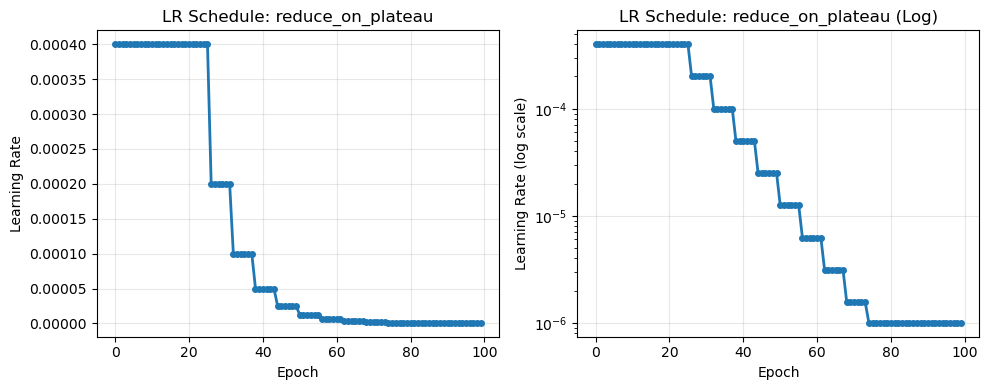

📈 LR Schedule Preview:
   Epoch  1: 4.00e-04
   Epoch  2: 4.00e-04
   Epoch  3: 4.00e-04
   Epoch  4: 4.00e-04
   Epoch  5: 4.00e-04
   Epoch  6: 4.00e-04
   Epoch  7: 4.00e-04
   Epoch  8: 4.00e-04
   Epoch  9: 4.00e-04
   Epoch 10: 4.00e-04
   ...     : ...
   Epoch 100: 1.00e-06


In [12]:
# Learning Rate Scheduler 설정
def create_lr_scheduler(optimizer, config):
    """Configuration에 따라 적절한 LR scheduler를 생성합니다."""
    
    if config.lr_scheduler is None:
        print("🚫 Learning rate scheduler: None (constant LR)")
        return None
    
    elif config.lr_scheduler == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=config.cosine_T_max,
            eta_min=config.cosine_eta_min
        )
        print(f"📊 Learning rate scheduler: CosineAnnealingLR")
        print(f"   T_max: {config.cosine_T_max}, eta_min: {config.cosine_eta_min}")
        return scheduler
    
    elif config.lr_scheduler == 'cosine_warm_restarts':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=config.wr_T_0,
            T_mult=config.wr_T_mult,
            eta_min=config.wr_eta_min
        )
        print(f"🔄 Learning rate scheduler: CosineAnnealingWarmRestarts")
        print(f"   T_0: {config.wr_T_0}, T_mult: {config.wr_T_mult}, eta_min: {config.wr_eta_min}")
        return scheduler
    
    elif config.lr_scheduler == 'reduce_on_plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',  # validation loss를 minimize
            factor=config.rop_factor,
            patience=config.rop_patience,
            min_lr=config.rop_min_lr,
        )
        print(f"📉 Learning rate scheduler: ReduceLROnPlateau")
        print(f"   factor: {config.rop_factor}, patience: {config.rop_patience}, min_lr: {config.rop_min_lr}")
        return scheduler
    
    else:
        print(f"❌ Unknown scheduler: {config.lr_scheduler}, using None")
        return None

# Scheduler 생성
lr_scheduler = create_lr_scheduler(optimizer, scfg)

print(f"\n🎯 Current configuration:")
print(f"   Initial LR: {scfg.lr}")
print(f"   Scheduler: {scfg.lr_scheduler}")
print(f"   Epochs: {scfg.epochs}")

# 스케줄러별 LR 변화 시뮬레이션 (시각화용)
def simulate_lr_schedule(config, num_epochs=20):
    """LR 스케줄 변화를 시뮬레이션합니다."""
    import copy
    
    # 임시 optimizer 생성
    temp_param = torch.nn.Parameter(torch.randn(1))
    temp_opt = torch.optim.AdamW([temp_param], lr=config.lr)
    temp_scheduler = create_lr_scheduler(temp_opt, config)
    
    lrs = []
    val_losses = [1.0, 0.9, 0.85, 0.8, 0.85, 0.82, 0.81, 0.80, 0.82, 0.79,
                  0.78, 0.77, 0.78, 0.76, 0.75, 0.76, 0.74, 0.73, 0.74, 0.72]  # 가상의 validation loss
    
    for epoch in range(num_epochs):
        lrs.append(temp_opt.param_groups[0]['lr'])
        
        if temp_scheduler is not None:
            if config.lr_scheduler == 'reduce_on_plateau':
                # ReduceLROnPlateau의 경우 validation loss 필요
                val_loss = val_losses[epoch] if epoch < len(val_losses) else val_losses[-1]
                temp_scheduler.step(val_loss)
            else:
                # 다른 스케줄러는 epoch만 필요
                temp_scheduler.step()
    
    return lrs

# LR 스케줄 시각화
if scfg.lr_scheduler is not None:
    lrs = simulate_lr_schedule(scfg, scfg.epochs)
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(lrs, 'o-', linewidth=2, markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title(f'LR Schedule: {scfg.lr_scheduler}')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(lrs, 'o-', linewidth=2, markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate (log scale)')
    plt.title(f'LR Schedule: {scfg.lr_scheduler} (Log)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 LR Schedule Preview:")
    for i, lr in enumerate(lrs[:10]):  # 처음 10 epoch만 표시
        print(f"   Epoch {i+1:2d}: {lr:.2e}")
    if len(lrs) > 10:
        print(f"   ...     : ...")
        print(f"   Epoch {len(lrs):2d}: {lrs[-1]:.2e}")
else:
    print("📊 No scheduler selected - constant learning rate will be used.")

# 10. Execute training loop

In [ ]:
# Enhanced Training Loop with Physics Loss and Learning Rate Scheduler
def train_with_scheduler(model, optim, scheduler, train_loader, val_loader, 
                        scfg, device, scaler=None, physics_loss_fn=None):
    """
    Physics loss와 스케줄러를 포함한 완전한 훈련 루프
    
    Args:
        model: 훈련할 모델
        optimizer: 최적화기
        scheduler: LR 스케줄러 (None 가능)
        train_loader, val_loader: 데이터 로더
        scfg: 설정 객체
        device: 디바이스
        scaler: GradScaler (AMP용)
        physics_loss_fn: Physics-informed loss function
    
    Returns:
        training_history: 상세한 훈련 기록
    """
    
    # Training history tracking
    history = {
        'train_total_loss': [],
        'train_mse_loss': [],
        'train_continuity_loss': [],
        'train_momentum_loss': [],
        'val_total_loss': [],
        'val_mse_loss': [], 
        'val_continuity_loss': [],
        'val_momentum_loss': [],
        'lr_history': [],
        'best_val_loss': float('inf'),
        'best_epoch': 0
    }
    
    physics_enabled = physics_loss_fn is not None
    print(f"🚀 Starting training with {scfg.lr_scheduler} scheduler")
    print(f"   Physics Loss: {'✅ ENABLED' if physics_enabled else '❌ DISABLED'}")
    print(f"   Epochs: {scfg.epochs}")
    print(f"   Initial LR: {optimizer.param_groups[0]['lr']:.2e}")
    if physics_enabled:
        print(f"   Continuity weight: {physics_loss_fn.cont_w}")
        print(f"   Momentum weight: {physics_loss_fn.mom_w}")
    print("=" * 70)

    global_step = 0  # 전체 훈련 과정에서의 step 추적용
    
    try:
        for epoch in range(scfg.epochs):
            # 현재 learning rate 기록
            current_lr = optimizer.param_groups[0]['lr']
            history['lr_history'].append(current_lr)
            
            # 훈련 phase
            train_total, train_logs, global_step = train_epoch(
                train_loader, model, optim, device, scaler,
                desc=f"train[{epoch}]", loss_fn=loss_fn, global_step_start=global_step
            )

            history['train_total_loss'].append(train_total)
            history['train_mse_loss'].append(train_logs['mse_loss'])
            history['train_continuity_loss'].append(train_logs.get('continuity_loss', 0.0))
            history['train_momentum_loss'].append(train_logs.get('momentum_loss', 0.0))

            # Validation phase
            val_loss, val_losses = run_epoch(
                val_loader, model, device, scaler, 
                f'Val {epoch+1}/{scfg.epochs}',
                loss_fn=physics_loss_fn
            )
            
            history['val_total_loss'].append(val_losses['total_loss'])
            history['val_mse_loss'].append(val_losses['mse_loss']) 
            history['val_continuity_loss'].append(val_losses.get('continuity_loss', 0.0))
            history['val_momentum_loss'].append(val_losses.get('momentum_loss', 0.0))

            # Learning rate scheduler step
            if scheduler is not None:
                if scfg.lr_scheduler == 'reduce_on_plateau':
                    # ReduceLROnPlateau는 validation loss를 기준으로 스케줄링
                    scheduler.step(val_loss)
                else:
                    # 다른 스케줄러들은 epoch 기준
                    scheduler.step()
            
            # 새로운 learning rate 출력
            new_lr = optimizer.param_groups[0]['lr']
            lr_changed = abs(new_lr - current_lr) > 1e-10
            
            # 결과 출력
            if physics_enabled:
                print(f"Epoch {epoch+1:3d}: "
                      f"train={train_losses['total_loss']:.6f} "
                      f"(mse:{train_losses['mse_loss']:.6f}, "
                      f"cont:{train_losses['continuity_loss']:.6f}, "
                      f"mom:{train_losses['momentum_loss']:.6f}), "
                      f"val={val_losses['total_loss']:.6f} "
                      f"(mse:{val_losses['mse_loss']:.6f}, "
                      f"cont:{val_losses['continuity_loss']:.6f}, "
                      f"mom:{val_losses['momentum_loss']:.6f}), "
                      f"lr={new_lr:.2e}" + 
                      (f" 📉" if lr_changed else "") +
                      f" | PhysW: {physics_loss_fn.continuity_loss_weight:.2f}")
            else:
                print(f"Epoch {epoch+1:3d}: "
                      f"train_loss={train_losses['total_loss']:.6f}, "
                      f"val_loss={val_losses['total_loss']:.6f}, "
                      f"lr={new_lr:.2e}" + 
                      (f" 📉" if lr_changed else ""))
            
            # Best model tracking
            if val_loss < history['best_val_loss']:
                history['best_val_loss'] = val_loss
                history['best_epoch'] = epoch + 1
                print(f"   ✨ New best validation loss: {history['best_val_loss']:.6f}")
                # 여기서 모델 저장 가능
                # torch.save(model.state_dict(), 'best_model.pt')
    
    except torch.cuda.OutOfMemoryError:
        print("\n" + "="*70)
        print("🛑 CUDA out of memory during training. The kernel will not crash.")
        print("   Consider reducing `batch_size` or model `hidden` size in the configuration.")
        print("="*70)
        # Clean up to allow other cells to run
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    except Exception as e:
        print("\n" + "="*70)
        print(f"🛑 An unexpected error occurred during training: {e}")
        print("   Training stopped. The kernel will not crash.")
        print("="*70)
        # Clean up
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print("=" * 70)
    print(f"🎯 Training completed!")
    if history['train_total_loss']:
        print(f"   Final train loss: {history['train_total_loss'][-1]:.6f}")
        print(f"   Final val loss: {history['val_total_loss'][-1]:.6f}")
        print(f"   Best val loss: {history['best_val_loss']:.6f} (epoch {history['best_epoch']})")
        print(f"   Final LR: {history['lr_history'][-1]:.2e}")
    
        if physics_enabled and history['train_continuity_loss']:
            print(f"   Final continuity losses:")
            print(f"      Train: {history['train_continuity_loss'][-1]:.6e}")
            print(f"      Val:   {history['val_continuity_loss'][-1]:.6e}")
    else:
        print("   No epochs were completed.")
    
    return history

# 훈련 실행 함수 (Physics Loss 지원)
def run_training_experiment(config_updates=None, physics_config_updates=None):
    """
    설정을 업데이트하고 physics loss와 함께 훈련을 실행합니다.
    
    Args:
        config_updates: 모델 설정 변경 딕셔너리 (예: {'lr_scheduler': 'cosine'})
        physics_config_updates: Physics loss 설정 변경 딕셔너리
    """
    
    # 설정 업데이트
    if config_updates:
        for key, value in config_updates.items():
            setattr(scfg, key, value)
        print(f"🔧 Model configuration updated: {config_updates}")
    


    # 새로운 optimizer와 scheduler 생성
    optimizer = torch.optim.AdamW(model.parameters(), 
                                 lr=scfg.lr, 
                                 weight_decay=scfg.weight_decay, 
                                 betas=scfg.betas, 
                                 eps=scfg.eps)
    
    scheduler = create_lr_scheduler(optimizer, scfg)
    
    # GradScaler for AMP
    scaler = torch.cuda.amp.GradScaler() if scfg.amp and torch.cuda.is_available() else None
    
    # 훈련 실행
    history = train_with_scheduler(
        model, optimizer, scheduler, train_loader, val_loader, 
        scfg, device, scaler, physics_loss_fn=loss_fn
    )
    
    return history


# 스케줄러 및 Physics Loss 테스트
print(f"Current scheduler: {scfg.lr_scheduler}")

if lr_scheduler is None:
    print("⚠️  No scheduler active - training with constant LR")
else:
    print(f"✅ Scheduler ready: {type(lr_scheduler).__name__}")

print(f"\n🧪 Running test training with physics loss...")

# 짧은 훈련으로 테스트 (physics loss 포함)
test_history = run_training_experiment()

print(f"\n📊 Test Results with Physics Loss:")
if test_history['lr_history']:
    print(f"   LR progression: {' -> '.join([f'{lr:.2e}' for lr in test_history['lr_history']])}")
    print(f"   Train losses (total): {' -> '.join([f'{loss:.4f}' for loss in test_history['train_total_loss']])}")
    print(f"   Train losses (continuity): {' -> '.join([f'{loss:.2e}' for loss in test_history['train_continuity_loss']])}")
    print(f"   Val losses (total): {' -> '.join([f'{loss:.4f}' for loss in test_history['val_total_loss']])}")
    print(f"   Val losses (continuity): {' -> '.join([f'{loss:.2e}' for loss in test_history['val_continuity_loss']])}")
else:
    print("   Training was interrupted before any results could be recorded.")


Current scheduler: reduce_on_plateau
✅ Scheduler ready: ReduceLROnPlateau

🧪 Running test training with physics loss...
📉 Learning rate scheduler: ReduceLROnPlateau
   factor: 0.5, patience: 5, min_lr: 1e-06
🚀 Starting training with reduce_on_plateau scheduler
   Physics Loss: ✅ ENABLED
   Epochs: 100
   Initial LR: 4.00e-04
   Continuity weight: 0.2
   Momentum weight: 0.2


Epoch 1/100:   0%|          | 0/180 [00:00<?, ?it/s]

Val 1/100:   0%|          | 0/20 [00:00<?, ?it/s]


[DEBUG SAMPLE]
uref_used => 75.02999877929688
mol_coeff => 1.999200352398109e-07
div => {'n': 15988, 'mean': -0.0011211135424673557, 'std': 0.182281494140625, 'min': -0.7777560949325562, 'max': 0.7769923210144043, 'p50': -0.0002525246818549931, 'p90': 0.2245229333639145, 'p99': 0.483932763338089, 'nan': 0, 'inf': 0}
|grad u*| => {'n': 15988, 'mean': 0.007390404585748911, 'std': 0.0692356750369072, 'min': 0.0, 'max': 1.9216458797454834, 'p50': 0.00025745079619809985, 'p90': 0.0011025412240996957, 'p99': 0.2546645700931549, 'nan': 0, 'inf': 0}
|grad v*| => {'n': 15988, 'mean': 0.0017906681168824434, 'std': 0.0157756544649601, 'min': 0.0, 'max': 0.36517781019210815, 'p50': 0.00010720016871346161, 'p90': 0.00041368845268152654, 'p99': 0.049230773001909256, 'nan': 0, 'inf': 0}
lap_u* => {'n': 15988, 'mean': 0.551021158695221, 'std': 41.150978088378906, 'min': -1423.1705322265625, 'max': 1525.6038818359375, 'p50': 6.941627361811697e-08, 'p90': 0.02881850115954876, 'p99': 20.228721618652344,

Epoch 2/100:   0%|          | 0/180 [00:00<?, ?it/s]

Val 2/100:   0%|          | 0/20 [00:00<?, ?it/s]


[DEBUG SAMPLE]
uref_used => 75.02999877929688
mol_coeff => 1.999200352398109e-07
div => {'n': 15988, 'mean': -0.0011285956716164947, 'std': 0.18339593708515167, 'min': -0.7824649214744568, 'max': 0.7817492485046387, 'p50': -0.0002506703604012728, 'p90': 0.22591383755207062, 'p99': 0.4866739511489868, 'nan': 0, 'inf': 0}
|grad u*| => {'n': 15988, 'mean': 0.005424524657428265, 'std': 0.047718364745378494, 'min': 0.0, 'max': 1.0845112800598145, 'p50': 5.089681872050278e-05, 'p90': 0.0002637244469951838, 'p99': 0.2919168472290039, 'nan': 0, 'inf': 0}
|grad v*| => {'n': 15988, 'mean': 0.0004915184690617025, 'std': 0.004377573728561401, 'min': 0.0, 'max': 0.13503305613994598, 'p50': 1.5539832020294853e-05, 'p90': 7.363966142293066e-05, 'p99': 0.0225049015134573, 'nan': 0, 'inf': 0}
lap_u* => {'n': 15988, 'mean': 0.11377106606960297, 'std': 7.00763463973999, 'min': -201.38540649414062, 'max': 195.1726531982422, 'p50': 1.0847903020305694e-08, 'p90': 0.005628895480185747, 'p99': 8.829257011413

Epoch 3/100:   0%|          | 0/180 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
from utils import get_surface_mask, ensure_edge_features

# 14b) MSE per target (all, surface, volume) — computed in NORMALIZED space
@torch.no_grad()
def _surface_volume_masks_from_orig(d: Data):
    # Surface: non-zero normal vectors; Volume: zero normal vectors (use original, unnormalized normals)
    x = d.x
    if x is not None and x.size(1) >= 5:
        nxy = x[:, 3:5]
        surf = (nxy.abs().sum(dim=1) > 0)
    else:
        # Fallback to earlier heuristic
        surf = get_surface_mask(d)
    vol = ~surf
    return surf, vol

@torch.no_grad()
def _predict_one_local(d: Data):
    # Ensure pos3 and edges; normalize x; predict; keep EVERYTHING in normalized space for eval
    dm = Data(**{k: v for k, v in d})
    if dm.x.size(1) == 5 or not getattr(dm, 'pos2_appended', False):
        dm = with_pos2(dm)
    # edges must already exist; do not build inline
    assert hasattr(dm,'edge_index') and dm.edge_index is not None, 'edge_index missing'
    dm = ensure_edge_features(dm, want_dim=5)

    # Build a CPU copy with normalized x/y for evaluation and metrics
    dm_norm = Data(**{k: v for k, v in dm})
    dm_norm.x = x_scaler.transform(dm.x)
    dm_norm.y = y_scaler.transform(dm.y)
    dm_norm.x_norm_params = {'mean': x_scaler.mean.clone(), 'scale': x_scaler.std.clone()}
    dm_norm.y_norm_params = {'mean': y_scaler.mean.clone(), 'scale': y_scaler.std.clone()}

    # Forward on device, return prediction in normalized space on CPU
    dm_run = dm_norm.to(device)
    with torch.amp.autocast(device_type='cuda', enabled=(scfg.amp and torch.cuda.is_available())) if torch.cuda.is_available() else contextlib.nullcontext():
        y_pred_norm = model(dm_run).detach().cpu()
    return dm_norm, y_pred_norm

@torch.no_grad()
def mse_per_channel(y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.Tensor | None = None):
    # Ensure both tensors (and mask) are on the same device as y_pred
    dev = y_pred.device
    y_t = y_true.to(dev)
    if mask is not None:
        m = mask.to(dev)
        y_p = y_pred[m]
        y_t = y_t[m]
    else:
        y_p = y_pred
    err = (y_p - y_t) ** 2
    if err.numel() == 0:
        return [float('nan')] * y_true.size(1)
    return [float(err[:, i].mean().item()) for i in range(y_true.size(1))]

# Pick a sample (val if available else train) and report MSE splits (normalized space)
if isinstance(val_edges, list) and len(val_edges) > 0:
    d_eval = val_edges[0]
else:
    d_eval = train_edges[0] if len(train_edges) > 0 else None

if d_eval is not None:
    # Use original graph (unnormalized x) only for surface/volume masks
    d_orig = d_eval
    dm_eval_norm, y_pred_eval_norm = _predict_one_local(d_orig)
    surf_mask, vol_mask = _surface_volume_masks_from_orig(d_orig)

    names = ['u', 'v', 'p_over_rho', 'nu_t']
    mse_all = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, None)
    mse_surf = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, surf_mask)
    mse_vol  = mse_per_channel(y_pred_eval_norm, dm_eval_norm.y, vol_mask)

    print('[MSE | ALL   | normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_all)})
    print('[MSE | SURF  | normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_surf)})
    print('[MSE | VOLUME| normalized]', {n: f'{v:.4e}' for n, v in zip(names, mse_vol)})
else:
    print('No sample available for MSE computation')

[MSE | ALL   | normalized] {'u': '1.3308e+00', 'v': '3.8001e-01', 'p_over_rho': '6.1767e-02', 'nu_t': '1.6063e+00'}
[MSE | SURF  | normalized] {'u': '6.1226e+00', 'v': '4.0493e-01', 'p_over_rho': '5.4391e-01', 'nu_t': '2.8428e-02'}
[MSE | VOLUME| normalized] {'u': '1.0055e+00', 'v': '3.7831e-01', 'p_over_rho': '2.9036e-02', 'nu_t': '1.7134e+00'}


# Result Visualization

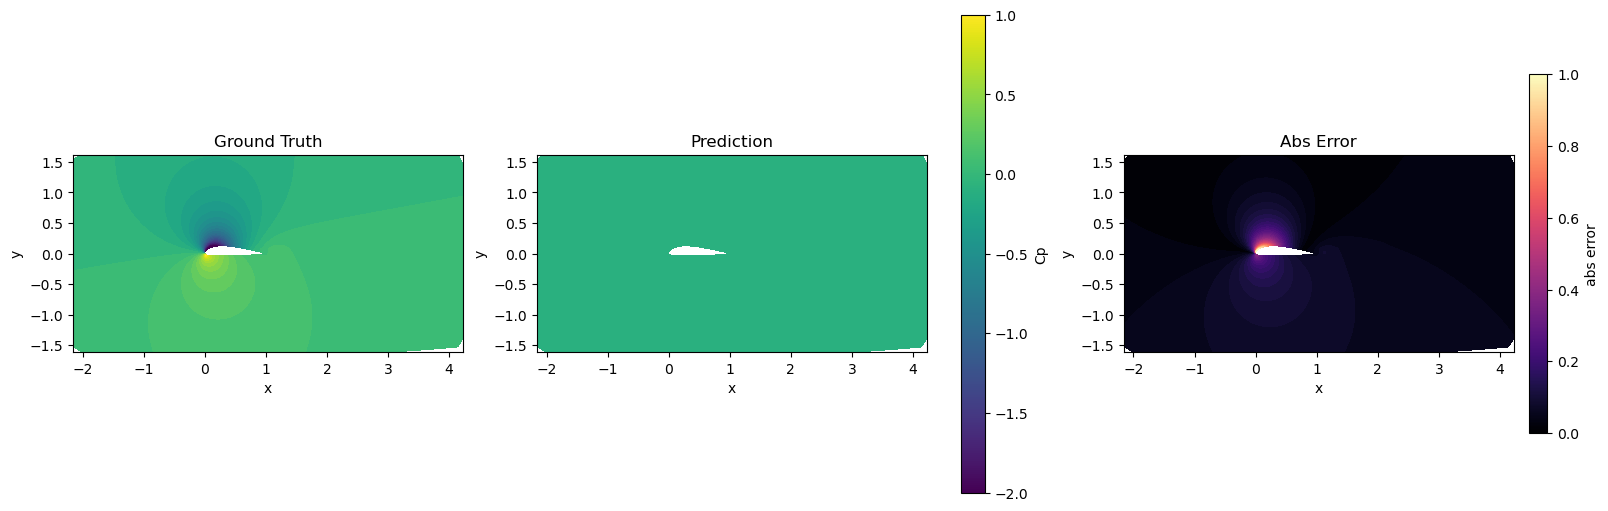

In [19]:
# 15) Visualization: GT vs Prediction (tricontour with optional mask)
from matplotlib.tri import Triangulation
from matplotlib.path import Path
from utils import _poly_from_surface

@torch.no_grad()
def _predict_one_for_viz(d: Data):
    # Ensure pos3 + edges, normalize x/y, forward, return normalized dm and y_pred_norm
    dm = Data(**{k: v for k, v in d})
    if dm.x.size(1) == 5 or not getattr(dm, 'pos2_appended', False):
        dm = with_pos2(dm)
    assert hasattr(dm,'edge_index') and dm.edge_index is not None, 'edge_index missing'
    dm = ensure_edge_features(dm, want_dim=5)
    dm_norm = Data(**{k: v for k, v in dm})
    dm_norm.x = x_scaler.transform(dm.x)
    dm_norm.y = y_scaler.transform(dm.y)
    dm_run = dm_norm.to(device)
    
    # Temporarily disable AMP for visualization to avoid dtype issues
    model.eval()
    # Force float32 for visualization to avoid AMP dtype conflicts
    if hasattr(dm_run, 'x'):
        dm_run.x = dm_run.x.float()
    if hasattr(dm_run, 'edge_attr'):
        dm_run.edge_attr = dm_run.edge_attr.float()
        
    y_pred_norm = model(dm_run).detach().cpu()
    return dm_norm, y_pred_norm

@torch.no_grad()
def plot_pred_vs_gt(dm: Data, y_pred: torch.Tensor, channel: int = 2, show_mesh: bool = True, mask_airfoil: bool = True,
                    titles: tuple[str,str,str] = ('Ground Truth','Prediction','Abs Error'), cmap: str = 'viridis',
                    denormalize: bool = True):
    # Optionally denormalize both GT and prediction for visualization
    if denormalize and hasattr(dm, 'y'):
        dm_y_cpu = dm.y.detach().cpu()
        y_pred_cpu = y_pred.detach().cpu()
        gt = y_scaler.inverse(dm_y_cpu)
        pr = y_scaler.inverse(y_pred_cpu)
    else:
        gt = dm.y.detach().cpu()
        pr = y_pred.detach().cpu()

    # Prepare coordinates and values
    xy = (dm.pos if hasattr(dm,'pos') and dm.pos is not None else dm.x)[:, :2].detach().cpu().float().numpy()
    tri = Triangulation(xy[:,0], xy[:,1])

    # Denormalize x to physical for q and for robust airfoil polygon detection
    dm_x_cpu = dm.x.detach().cpu()
    x_phys = x_scaler.inverse(dm_x_cpu)  # columns: [u, v, ..., nx, ny, ...]
    vx = float(x_phys[0, 0]); vy = float(x_phys[0, 1])
    v = math.sqrt(vx*vx + vy*vy)
    q = 0.5 * v * v

    gt_c = gt[:, channel].detach().cpu().float().numpy() / q
    pr_c = pr[:, channel].detach().cpu().float().numpy() / q
    err = np.abs(pr_c - gt_c)
    vmin = -2.0; vmax = 1.0

    # Optional mask of airfoil interior (build polygon locally from denormalized normals)
    if mask_airfoil:
        try:
            # Build surface mask directly from denormalized x (ignore any pre-existing d.surf)
            x_np = x_phys.detach().cpu().numpy() if isinstance(x_phys, torch.Tensor) else np.asarray(x_phys)
            pos_np = (dm.pos if hasattr(dm,'pos') and dm.pos is not None else dm.x)[:, :2].detach().cpu().numpy()
            surf_mask = None
            try:
                wall = x_np[:, 2] if x_np.shape[1] >= 3 else None
                nxy = x_np[:, 3:5] if x_np.shape[1] >= 5 else None
                if nxy is not None:
                    surf_mask = (np.abs(nxy).sum(axis=1) > 1e-8)
                    if wall is not None:
                        surf_mask = np.logical_or(surf_mask, (wall < 1e-6))
                elif wall is not None:
                    surf_mask = (wall < 1e-6)
            except Exception:
                surf_mask = None

            poly = None
            if surf_mask is not None and np.any(surf_mask):
                pts = pos_np[surf_mask]
                if pts.shape[0] >= 3:
                    c = pts.mean(axis=0)
                    ang = np.arctan2(pts[:,1]-c[1], pts[:,0]-c[0])
                    order = np.argsort(ang)
                    poly = Path(pts[order], closed=True)

            if poly is not None:
                tris = tri.triangles
                centers = np.mean(np.stack([tri.x[tris], tri.y[tris]], axis=-1), axis=1)
                # Slightly negative radius to shrink polygon inward and avoid boundary leakage
                inside = poly.contains_points(centers, radius=-1e-6)
                if inside is not None and inside.any():
                    tri.set_mask(inside.astype(bool))
        except Exception:
            # keep plotting even if masking fails
            pass

    fig, ax = plt.subplots(1, 3, figsize=(16,5), constrained_layout=True)
    a1,a2,a3 = ax
    c1 = a1.tricontourf(tri, gt_c, levels=50, vmin=vmin, vmax=vmax, cmap=cmap)
    c2 = a2.tricontourf(tri, pr_c, levels=50, vmin=vmin, vmax=vmax, cmap=cmap)
    c3 = a3.tricontourf(tri, err, levels=50, cmap='magma')
    if show_mesh:
        for a in (a1,a2,a3):
            a.triplot(tri, color='k', lw=0.25, alpha=0.35)
    for a, t in zip((a1,a2,a3), titles):
        a.set_aspect('equal','box'); a.set_title(t); a.set_xlabel('x'); a.set_ylabel('y')
    m1 = plt.cm.ScalarMappable(cmap=cmap); m1.set_clim(vmin,vmax)
    fig.colorbar(m1, ax=[a1,a2], fraction=0.046, pad=0.04, label=f'Cp')
    fig.colorbar(plt.cm.ScalarMappable(cmap='magma'), ax=a3, fraction=0.046, pad=0.04, label='abs error')
    plt.show()

# Example: visualize one sample (val if available, else train) — denormalized to capture actual flow physics
if isinstance(val_edges, list) or len(val_edges)==0:
    d_vis = train_edges[0] if len(train_edges)>0 else None
else:
    d_vis = val_edges[0] if len(val_edges)>0 else (train_edges[0] if len(train_edges)>0 else None)

if d_vis is not None:
    dm_vis_n, y_pred_vis_n = _predict_one_for_viz(d_vis)
    # Plot for pressure by default (channel 2). Change channel as needed (0=u, 1=v, 2=p_over_rho, 3=nu_t).
    plot_pred_vs_gt(dm_vis_n, y_pred_vis_n, channel=2, show_mesh=False, denormalize=True)
else:
    print('No sample available for visualization')


### Navier-Stokes Residual 검증

Ground Truth 데이터를 사용하여 Momentum Loss가 0에 가까운지 확인합니다.

1.  **데이터 로드**: `val_loader`에서 데이터 배치 하나를 가져옵니다.
2.  **Loss 함수 준비**: `NavierStokesPhysicsLoss` 인스턴스를 생성합니다.
3.  **Ground Truth로 예측**: 모델의 예측값 대신 Ground Truth(`batch.y`)를 그대로 사용하여 Loss를 계산합니다.
4.  **결과 확인**: 계산된 `momentum_loss`가 0에 매우 가까운 값인지 확인합니다. 이상적인 CFD 데이터라면 물리 법칙을 만족하므로 Loss가 거의 0이 되어야 합니다.
<VSCode.Cell language="python">

In [ ]:
import torch
import gc

# --- 1. 데이터 로드 ---
print("📦 Loading one batch from the validation set...")
try:
    val_iterator = iter(val_loader)
    gt_batch = next(val_iterator)
    gt_batch = gt_batch.to(device)
    print("   Batch loaded successfully to device.")
except Exception as e:
    print(f"   ❌ Error loading batch: {e}")
    gt_batch = None

if gt_batch is not None:
    # --- 2. Loss 함수 준비 ---
    # use_comprehensive_physics=True로 설정하여 전체 Navier-Stokes 항을 모두 계산
    print("\n🔬 Initializing NavierStokesPhysicsLoss for validation...")
    
    # --- 3. Ground Truth로 Loss 계산 ---
    print("\n🧮 Calculating residuals using ground truth data as prediction...")
    
    # 모델 예측 대신 Ground Truth(gt_batch.y)를 사용
    predicted_nodes_gt = gt_batch.y
    target_nodes_gt = gt_batch.y
    
    try:
        # --- 모멘텀 손실만 계산 ---
        # continuity_loss_weight를 0으로 설정하여 모멘텀 손실만 계산
        momentum_loss_fn = NavierStokesPhysicsLoss(
            data_loss_weight=0.0,
            continuity_loss_weight=0.0,
            momentum_loss_weight=1.0,
            use_comprehensive_physics=True
        )
        with torch.amp.autocast('cuda', enabled=scfg.amp):
            _, losses_mom = momentum_loss_fn(
                gt_batch, 
                predicted_nodes_gt, 
                target_nodes_gt
            )
        momentum_loss_gt = losses_mom['momentum_loss']

        # --- 연속성 손실만 계산 ---
        # momentum_loss_weight를 0으로 설정하여 연속성 손실만 계산
        continuity_loss_fn = NavierStokesPhysicsLoss(
            data_loss_weight=0.0,
            continuity_loss_weight=1.0,
            momentum_loss_weight=0.0,
            use_comprehensive_physics=True
        )
        with torch.amp.autocast('cuda', enabled=scfg.amp):
            _, losses_cont = continuity_loss_fn(
                predicted_nodes=predicted_nodes_gt,
                graph=gt_batch,
                target_nodes=target_nodes_gt
            )
        continuity_loss_gt = losses_cont['continuity_loss']

        # --- 4. 결과 확인 ---
        print("\n" + "="*50)
        print("✅ Ground Truth Residual Calculation Results:")
        print(f"   Momentum Loss (Residual): {momentum_loss_gt:.6e}")
        print(f"   Continuity Loss (Residual): {continuity_loss_gt:.6e}")
        print("="*50)

        if momentum_loss_gt < 1e-4 and continuity_loss_gt < 1e-4:
            print("\n👍 The residuals are very close to zero, as expected.")
            print("   This indicates the physics loss calculation is likely correct.")
        else:
            print("\n⚠️ The residuals are higher than expected.")
            print("   This might indicate an issue in the loss calculation or that the ground truth data itself has some numerical inaccuracies.")

    except Exception as e:
        import traceback
        print(f"\n❌ An error occurred during loss calculation: {e}")
        traceback.print_exc()

    # 메모리 정리
    del gt_batch, predicted_nodes_gt, target_nodes_gt
    del momentum_loss_fn, continuity_loss_fn
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


📦 Loading one batch from the validation set...
   Batch loaded successfully to device.

🔬 Initializing NavierStokesPhysicsLoss for validation...

🧮 Calculating residuals using ground truth data as prediction...

❌ An error occurred during loss calculation: NavierStokesPhysicsLoss.__init__() got an unexpected keyword argument 'use_comprehensive_physics'


Traceback (most recent call last):
  File "C:\Users\Kim\AppData\Local\Temp\ipykernel_15456\600216081.py", line 30, in <module>
    momentum_loss_fn = NavierStokesPhysicsLoss(
                       ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: NavierStokesPhysicsLoss.__init__() got an unexpected keyword argument 'use_comprehensive_physics'


NameError: name 'momentum_loss_fn' is not defined